# Linear Regression from Scratch in PyTorch


Linear Regression is a foundational tool in the field of machine learning and statistics, used for predicting a continuous target variable based on one or more predictor variables. This guide delves into implementing linear regression in PyTorch, a leading deep learning library.

## Theoretical Background

Linear regression models the relationship between a dependent variable, `y`, and one or more independent variables, `X`, as a linear function:

$ y = Xw + b + \epsilon $

- $X$ represents the independent variables (features).
- $w$ is a weight matrix corresponding to the coefficients of the features.
- $b$ is the bias term, an intercept in the linear equation.
- $\epsilon$ is the error term, capturing the deviation of the predictions from the actual values.

The goal of linear regression is to find the optimal $w$ and $b$ that minimize the difference between predicted and actual values, typically using the Mean Squared Error (MSE) loss function:

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

Here, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value for the ith instance.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.tools import DataLoaderScratch, SGDScratch, TrainerScratch

## Data Preparation

### Synthetic Data Generation

We generate synthetic data to mimic a real-world linear relationship, adding Gaussian noise to simulate real-world data imperfections. This data serves as a playground to test our regression models.

In [2]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

c:\Users\woute\miniconda3\envs\d2l\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


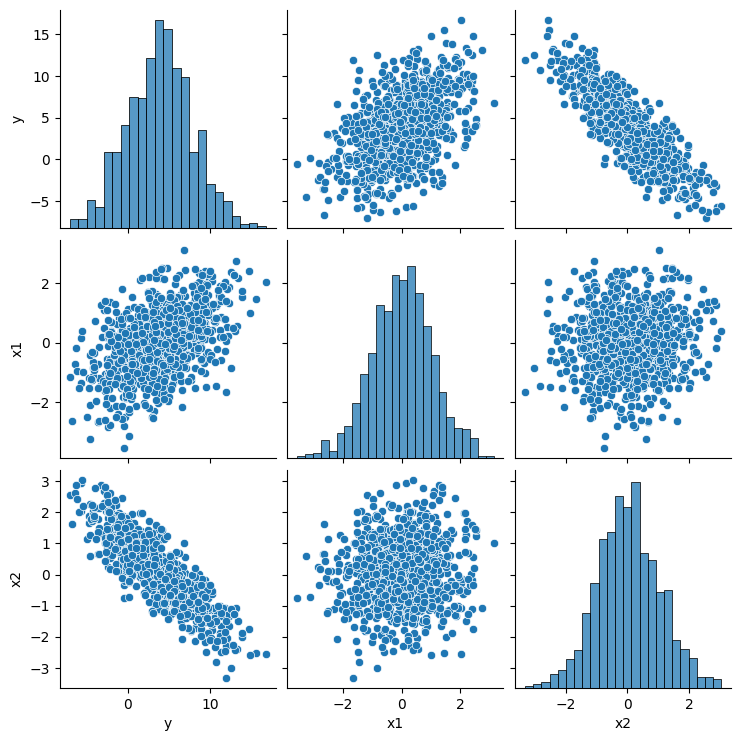

In [3]:
df = pd.DataFrame(torch.cat([y.reshape(-1, 1), X], dim=1), columns=["y", "x1", "x2"])
sns.pairplot(df)

### Data Splitting

The data is split into training and validation sets. The training set is used to train the model, and the validation set is used to evaluate its performance. This split helps in detecting overfitting and underfitting.

In [4]:
def train_test_split(X, y, train_size=0.8):
    # Shuffle the indices
    indices = torch.randperm(len(X)).tolist()

    # Calculate the number of samples in the training set
    train_size = int(train_size * len(X))

    # Slice the tensors to create training and validation sets
    X_train, y_train = X[indices[:train_size]], y[indices[:train_size]]
    X_val, y_val = X[indices[train_size:]], y[indices[train_size:]]

    return X_train, y_train, X_val, y_val

In [5]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.8)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

## Linear Regression from Scratch

### Single Batch Iteration

In [6]:
in_features = X_train.shape[1]
num_samples = X_train.shape[0]
batch_size = 512

# Initialize weights
w = torch.randn(in_features, 1, requires_grad=True)
b = torch.zeros(1, 1, requires_grad=True)

parameters = [w, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [7]:
# Zero gradients
optimizer.zero_grad()

# Forward pass (training)
y_pred = X_batch @ w + b

# Calculate Loss
def mse_loss(y_pred, y): 
    loss = torch.mean((y - y_pred) ** 2)
    return loss

loss = mse_loss(y_pred, y_batch)
# Backward pass (compute gradients)
loss.backward()

# Update parameters
optimizer.step()

In [8]:
loss

tensor(18.5310, grad_fn=<MeanBackward0>)

### Define Training Loop and Model

In [9]:
class LinearRegressionScratch(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        self.w = torch.randn(num_inputs, 1, requires_grad=True)
        self.b = torch.zeros(1, 1, requires_grad=True)

    def forward(self, X):
        y_pred = X @ self.w + self.b
        return y_pred
    
    def parameters(self):
        return [self.w, self.b]

### Training the Model

Epoch 1/15, Training Loss: 23.4813, Validation Loss: 20.7862
Epoch 2/15, Training Loss: 14.2535, Validation Loss: 12.7385
Epoch 3/15, Training Loss: 8.7243, Validation Loss: 7.8070
Epoch 4/15, Training Loss: 5.3266, Validation Loss: 4.8064
Epoch 5/15, Training Loss: 3.2895, Validation Loss: 2.9541
Epoch 6/15, Training Loss: 2.0600, Validation Loss: 1.7971
Epoch 7/15, Training Loss: 1.2310, Validation Loss: 1.1052
Epoch 8/15, Training Loss: 0.7702, Validation Loss: 0.6725
Epoch 9/15, Training Loss: 0.4646, Validation Loss: 0.4123
Epoch 10/15, Training Loss: 0.2846, Validation Loss: 0.2530
Epoch 11/15, Training Loss: 0.1749, Validation Loss: 0.1552
Epoch 12/15, Training Loss: 0.1094, Validation Loss: 0.0942
Epoch 13/15, Training Loss: 0.0670, Validation Loss: 0.0569
Epoch 14/15, Training Loss: 0.0395, Validation Loss: 0.0350
Epoch 15/15, Training Loss: 0.0247, Validation Loss: 0.0213


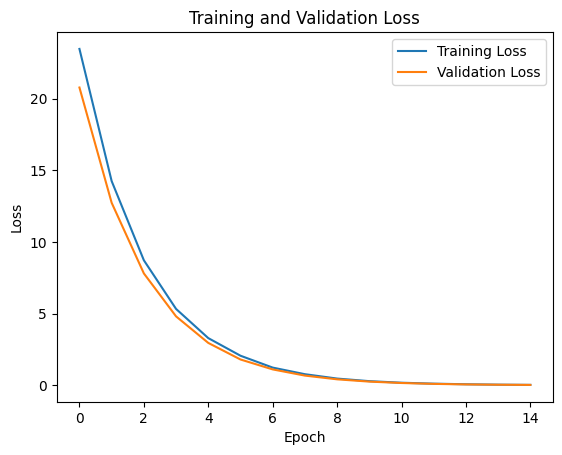

In [10]:
num_inputs = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01

model = LinearRegressionScratch(num_inputs=num_inputs)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion=mse_loss)
trainer.fit(num_epochs=num_epochs)

## Regularized Linear Regression From Scratch

Regularization is a technique to reduce overfitting. In `RegularizedLinearRegressionModel`, we add a regularization term to the loss function:

$ \text{Total Loss} = \text{MSE Loss} + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $

- $\lambda$ is the regularization strength.
- The regularization term penalizes large weights, encouraging simpler models.

In [18]:
n, d = 20, 200
X = torch.randn(n, d)
noise = torch.randn(n, 1) * 0.01
w, b = torch.ones((d, 1)) * 0.01, 0.05

1
y = torch.matmul(X, w) + b + noise

In [19]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.2)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

We compare the performance of the regularized model with different $\lambda$ values to illustrate the effect of regularization.

Epoch 1/15, Training Loss: 94.4804, Validation Loss: 218.9365
Epoch 2/15, Training Loss: 1.8061, Validation Loss: 216.5953
Epoch 3/15, Training Loss: 0.0561, Validation Loss: 217.0182
Epoch 4/15, Training Loss: 0.0020, Validation Loss: 216.9345
Epoch 5/15, Training Loss: 0.0001, Validation Loss: 216.9503
Epoch 6/15, Training Loss: 0.0000, Validation Loss: 216.9473
Epoch 7/15, Training Loss: 0.0000, Validation Loss: 216.9479
Epoch 8/15, Training Loss: 0.0000, Validation Loss: 216.9477
Epoch 9/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 10/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 11/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 12/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 13/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 14/15, Training Loss: 0.0000, Validation Loss: 216.9478
Epoch 15/15, Training Loss: 0.0000, Validation Loss: 216.9478


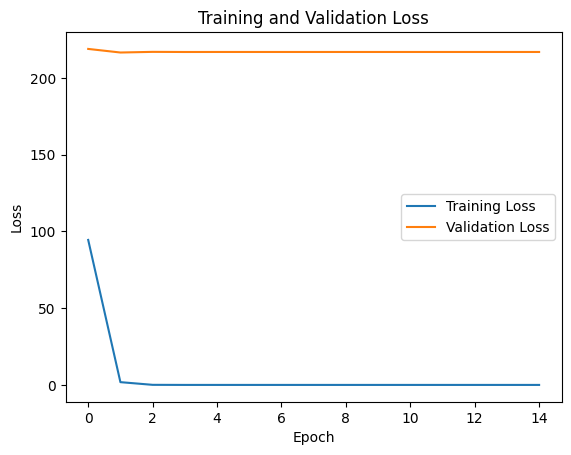

In [29]:
num_inputs = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01
weight_decay = 0

model = LinearRegressionScratch(num_inputs=num_inputs)
optimizer = SGDScratch(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion=mse_loss)
trainer.fit(num_epochs=num_epochs)

Epoch 1/10, Training Loss: 88.1532, Validation Loss: 436.6031
Epoch 2/10, Training Loss: 7347.0254, Validation Loss: 11850.8799
Epoch 3/10, Training Loss: 631321.6875, Validation Loss: 1049597.5000
Epoch 4/10, Training Loss: 56109640.0000, Validation Loss: 99233176.0000
Epoch 5/10, Training Loss: 5171859968.0000, Validation Loss: 9920526336.0000
Epoch 6/10, Training Loss: 495153938432.0000, Validation Loss: 1037800177664.0000
Epoch 7/10, Training Loss: 49229468794880.0000, Validation Loss: 112664038604800.0000
Epoch 8/10, Training Loss: 5071933322297344.0000, Validation Loss: 12580229792923648.0000
Epoch 9/10, Training Loss: 539448235974983680.0000, Validation Loss: 1433843426968731648.0000
Epoch 10/10, Training Loss: 58950351107582328832.0000, Validation Loss: 165808394162201952256.0000


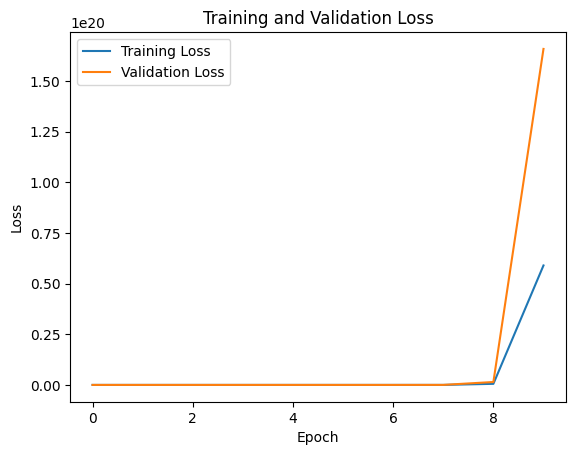

In [46]:
num_inputs = X_train.shape[1]
num_epochs = 10
learning_rate = 0.1
weight_decay = 0.01

model = LinearRegressionScratch(num_inputs=num_inputs)
optimizer = SGDScratch(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion=mse_loss)
trainer.fit(num_epochs=num_epochs)

Epoch 1/100, Training Loss: 1280.8250732421875, Validation Loss: 1390.4141845703125
Epoch 11/100, Training Loss: 957.0509643554688, Validation Loss: 1140.8026123046875
Epoch 21/100, Training Loss: 773.0617065429688, Validation Loss: 935.5841674804688
Epoch 31/100, Training Loss: 631.1663818359375, Validation Loss: 766.1572265625
Epoch 41/100, Training Loss: 516.0988159179688, Validation Loss: 626.9885864257812
Epoch 51/100, Training Loss: 422.1049499511719, Validation Loss: 512.9688110351562
Epoch 61/100, Training Loss: 345.2420349121094, Validation Loss: 419.6487121582031
Epoch 71/100, Training Loss: 282.3773193359375, Validation Loss: 343.29901123046875
Epoch 81/100, Training Loss: 230.9600830078125, Validation Loss: 280.84210205078125
Epoch 91/100, Training Loss: 188.9055938720703, Validation Loss: 229.75228881835938


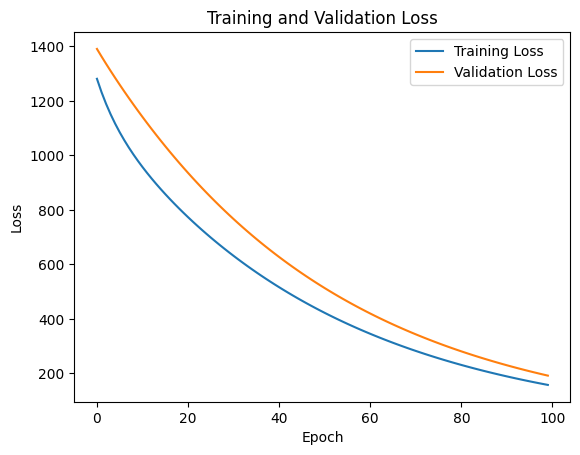

In [ ]:
num_epochs = 100
learning_rate = 0.001
lam = 10

model = RegularizedLinearRegressionScratch(in_features=X.shape[1], lam=lam)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
model.fit(train_dataloader, val_dataloader, num_epochs)

## Concise Implementation of Linear Regression with SGD

For a more concise implementation, we leverage PyTorch's built-in modules:

- **`nn.Linear`**: Defines a linear layer with weights and biases.
- **`optim.SGD`**: Stochastic Gradient Descent optimizer.
- **`nn.MSELoss`**: Mean Squared Error loss function.

These functions abstract away much of the manual work, allowing for a more streamlined and error-free implementation.

In [ ]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

In [ ]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression(X.shape[1])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Model
for epoch in range(100):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model.linear.weight

Parameter containing:
tensor([[ 2.0001, -3.3998]], requires_grad=True)